# DS4H - P2 Exploratory Data Analysis

Franklin, Ke, Spencer

To run this notebook, place the data files into a directory called 'data' that sits at the same location as this jupyter notebook. 

In [33]:
# Note: 
# If the theme of jupyter lab is in "Dark Mode" you won't be able to see the axis labels
# TO CHANGE THEME --> Settings --> Theme --> JupyterLab (Light/Dark)

from pathlib import Path 
from typing import Dict

import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from matplotlib.pyplot import figure
plt.style.use("fivethirtyeight")
from sklearn.metrics import mean_squared_error

import matplotlib.cm as cm
from matplotlib_venn import venn2
import seaborn as sns
%config InlineBackend.figure_formats = ['svg']
import matplotlib.pyplot as plt
%matplotlib inline

In [34]:
import pandas as pd

In [35]:
df = pd.read_sas('/Users/spencerbertsch/Desktop/PAXDAY_H.XPT')

In [36]:
df['SEQN'].value_counts()

73557.0    9
80317.0    9
80332.0    9
80331.0    9
80330.0    9
          ..
75310.0    1
78276.0    1
77092.0    1
83501.0    1
77446.0    1
Name: SEQN, Length: 7776, dtype: int64

In [37]:
round(df, 4)

,SEQN,PAXDAYD,PAXDAYWD,PAXSSNDP,PAXMSTD,PAXTMD,PAXAISMD,PAXVMD,PAXMTSD,PAXWWMD,PAXSWMD,PAXNWMD,PAXUMD,PAXLXSD,PAXQFD
0,73557.0,b'1',b'3',0.0,b'16:30:00',450.0,915200.0,450.0,4576.422,237.0,22.0,174.0,17.0,147049.33,0.0
1,73557.0,b'2',b'4',2160000.0,b' 0:00:00',1440.0,2989920.0,1440.0,12222.152,744.0,113.0,546.0,37.0,173340.75,0.0
2,73557.0,b'3',b'5',9072000.0,b' 0:00:00',1440.0,3307840.0,1440.0,3158.922,147.0,0.0,1287.0,6.0,83407.33,0.0
3,73557.0,b'4',b'6',15984000.0,b' 0:00:00',1440.0,6860400.0,1440.0,23.641,0.0,0.0,1439.0,1.0,0.00,0.0
4,73557.0,b'5',b'7',22896000.0,b' 0:00:00',1440.0,3968640.0,1440.0,8879.010,504.0,98.0,822.0,16.0,38649.85,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69013,83731.0,b'5',b'4',24048000.0,b' 0:00:00',1440.0,2531037.0,1440.0,15139.726,907.0,476.0,0.0,57.0,99812.08,0.0
69014,83731.0,b'6',b'5',30960000.0,b' 0:00:00',1440.0,1799439.0,1440.0,16633.798,1025.0,373.0,0.0,42.0,46428.19,0.0
69015,83731.0,b'7',b'6',37872000.0,b' 0:00:00',1440.0,1949914.0,1440.0,16923.717,997.0,393.0,0.0,50.0,163437.14,0.0
69016,83731.0,b'8',b'7',44784000.0,b' 0:00:00',1440.0,1608477.0,1440.0,20462.627,1010.0,382.0,0.0,48.0,632538.26,0.0


In [38]:
physical_activity_patient_ids: set = set(df['SEQN'])

In [39]:
df.shape

(69018, 15)

In [40]:
df_sleep = pd.read_sas('/Users/spencerbertsch/Desktop/SLQ_H.XPT')

In [41]:
df_sleep

,SEQN,SLD010H,SLQ050,SLQ060
0,73557.0,7.0,1.0,2.0
1,73558.0,9.0,2.0,2.0
2,73559.0,8.0,2.0,2.0
3,73561.0,9.0,2.0,2.0
4,73562.0,5.0,2.0,1.0
...,...,...,...,...
6459,83723.0,6.0,2.0,2.0
6460,83724.0,9.0,1.0,2.0
6461,83726.0,8.0,2.0,2.0
6462,83727.0,7.0,2.0,2.0


In [42]:
sleep_patient_ids: set = set(df_sleep['SEQN'])

In [55]:
def create_venn_2_sets(set1: set, set2: set, set1_name: str, set2_name: str):
    """
    This function can be used to create a venndiagram using two distinct sets of values. This function can be extended easily using the 'venn3' 
    library built using Matplotlib so that venn diagrams of 3 sets can be generated. 
    """
    figure(figsize=(6, 6), dpi=80)
    venn2([set1, set2], 
          (set1_name, set2_name), 
          set_colors=('purple', 'skyblue'), 
          alpha = 0.7)
    plt.show()

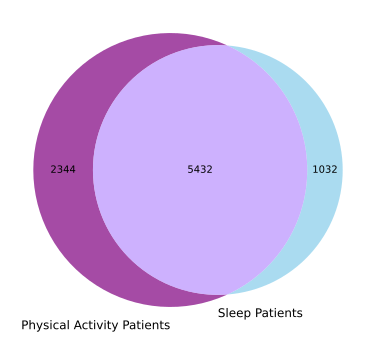

In [56]:
create_venn_2_sets(set1=physical_activity_patient_ids, set2=sleep_patient_ids, set1_name='Physical Activity Patients', set2_name='Sleep Patients')

This venn diagram shows us the set intersection betwen the patients included in each of the data sets that we're going to use. Our goal here is to combine the physical activity data and teh sleep data together, but we can only perform the join on **patient_id**. This plot shows us that even though we are losing 2,344 physical activity patients who don't have sleep data and 1,032 sleep patents who don't have physical activity data, we still have 5,432 patients to use in our analysis. 

## Join the physical activity and sleep data together 

In [17]:
df_joined = df.merge(df_sleep, left_on='SEQN', right_on='SEQN')

In [19]:
df_joined

,SEQN,PAXDAYD,PAXDAYWD,PAXSSNDP,PAXMSTD,PAXTMD,PAXAISMD,PAXVMD,PAXMTSD,PAXWWMD,PAXSWMD,PAXNWMD,PAXUMD,PAXLXSD,PAXQFD,SLD010H,SLQ050,SLQ060
0,73557.0,b'1',b'3',5.397605e-79,b'16:30:00',450.0,915200.0,450.0,4576.422,2.370000e+02,2.200000e+01,1.740000e+02,17.0,1.470493e+05,5.397605e-79,7.0,1.0,2.0
1,73557.0,b'2',b'4',2.160000e+06,b' 0:00:00',1440.0,2989920.0,1440.0,12222.152,7.440000e+02,1.130000e+02,5.460000e+02,37.0,1.733408e+05,5.397605e-79,7.0,1.0,2.0
2,73557.0,b'3',b'5',9.072000e+06,b' 0:00:00',1440.0,3307840.0,1440.0,3158.922,1.470000e+02,5.397605e-79,1.287000e+03,6.0,8.340733e+04,5.397605e-79,7.0,1.0,2.0
3,73557.0,b'4',b'6',1.598400e+07,b' 0:00:00',1440.0,6860400.0,1440.0,23.641,5.397605e-79,5.397605e-79,1.439000e+03,1.0,5.397605e-79,5.397605e-79,7.0,1.0,2.0
4,73557.0,b'5',b'7',2.289600e+07,b' 0:00:00',1440.0,3968640.0,1440.0,8879.010,5.040000e+02,9.800000e+01,8.220000e+02,16.0,3.864985e+04,5.397605e-79,7.0,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48351,83729.0,b'5',b'4',2.260800e+07,b' 0:00:00',1440.0,3502243.0,1440.0,8749.650,8.060000e+02,5.410000e+02,5.397605e-79,93.0,6.545710e+03,5.397605e-79,7.0,2.0,2.0
48352,83729.0,b'6',b'5',2.952000e+07,b' 0:00:00',1440.0,2809920.0,1440.0,11522.476,1.087000e+03,2.800000e+02,5.397605e-79,73.0,8.212960e+03,5.397605e-79,7.0,2.0,2.0
48353,83729.0,b'7',b'6',3.643200e+07,b' 0:00:00',1440.0,2777280.0,1440.0,12261.709,1.041000e+03,3.120000e+02,5.397605e-79,87.0,2.033331e+04,5.397605e-79,7.0,2.0,2.0
48354,83729.0,b'8',b'7',4.334400e+07,b' 0:00:00',1440.0,3054400.0,1440.0,11322.877,1.000000e+03,3.700000e+02,5.397605e-79,70.0,4.750330e+03,5.397605e-79,7.0,2.0,2.0
